In [1]:
# Import Basic Libraries
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pickle
import math
import joblib

# Import Neural Network Libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout,Bidirectional
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint

2023-04-08 02:14:17.641592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 02:14:17.885188: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-08 02:14:17.919359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-08 02:14:17.919374: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Create function to calculate root mean square error
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [3]:
# Read csv file
df=pd.read_csv('/home/tarunpreet/Desktop/Suraj/org_update.csv')

In [4]:
#Groupby dataframe 

newdf=df.groupby(['Month','Day']).agg({'Temp': ['mean'],'DHI':['mean'],'DNI':['mean'],'GHI':['mean'],
                                      'WindVel':['mean'],'Output_Power':['mean']})
newdf = newdf.reset_index()
newdf.columns=['Month','Day','Temp_Mean','DHI_Mean','DNI_Mean','GHI_Mean','WindVel_Mean','Output_Power_Mean']
newdf.to_csv('./avg.csv')

In [13]:
# Drop unnecessary columns in dataset
newdf1=newdf.drop(labels=['Month','Day'],axis=1)
X_data=newdf1.drop(labels=['Output_Power_Mean'],axis=1)
Y_data=newdf1['Output_Power_Mean']

In [14]:
# Scale the dataset to ensure that features are within the same scale using Standard Scaler
Xscaler = StandardScaler()
Xscaler.fit(X_data)
SXdata= Xscaler.transform(X_data)

In [15]:
Yscaler = StandardScaler()
Y_data=Y_data.to_numpy().reshape(-1,1)
Yscaler.fit(Y_data)
SYdata= Yscaler.transform(Y_data)

In [16]:
# Split data into windows
window_size=10
predictions=1
x=[]
y=[]
for i in range(0, len(newdf1.index)-10, predictions):
    x.append(SXdata[i:window_size+i])
    y.append(SYdata[window_size+i])

In [20]:
# Train Test Split
X_train,X_test,Y_train,Y_test=train_test_split(np.array(x), np.array(y),test_size=0.20,random_state=42)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(255, 10, 5) (255, 1) (64, 10, 5) (64, 1)


In [24]:
#Reshape train and test set for LSTM Model

trainX = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2])
testX = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])

In [27]:
# Define Long Short Term Memory (LSTM Model)
print('model used in LSTM')
lstm = Sequential()
lstm.add(LSTM(input_shape = (10,5),units= 30,  activation='relu',return_sequences = True))
lstm.add(LSTM(10))
lstm.add(Dense(5, activation='relu'))
lstm.add(Dense(1))
lstm.summary()

model used in LSTM
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 30)            4320      
                                                                 
 lstm_3 (LSTM)               (None, 10)                1640      
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 6,021
Trainable params: 6,021
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Early stopping stop training once the model performance stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')

Epoch 1/100
3/3 [==============================] - 3s 256ms/step - loss: 1.0288 - mae: 0.8460 - val_loss: 0.9503 - val_mae: 0.7944
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 1.0109 - mae: 0.8363 - val_loss: 0.9363 - val_mae: 0.7856
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.9930 - mae: 0.8263 - val_loss: 0.9206 - val_mae: 0.7779
Epoch 4/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9758 - mae: 0.8160 - val_loss: 0.9032 - val_mae: 0.7686
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9571 - mae: 0.8038 - val_loss: 0.8848 - val_mae: 0.7578
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9344 - mae: 0.7877 - val_loss: 0.8657 - val_mae: 0.7452
Epoch 7/100
3/3 [==============================] - 0s 20ms/step - loss: 0.9145 - mae: 0.7713 - val_loss: 0.8457 - val_mae: 0.7305
Epoch 8/100
3/3 [==============================] - 0s 27ms/step - loss: 0.8928 - mae: 0.7

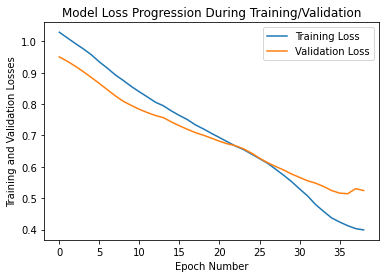

In [29]:
# Compile the model
lstm.compile(loss='mse', optimizer='adam',metrics=['mae'])
history_lstm = lstm.fit(trainX, Y_train, epochs = 100, verbose=1,validation_split=0.1,batch_size=100, callbacks=[early_stopping])
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [30]:
# Test the model
ytrain_pred=lstm.predict(trainX)
ytest_pred = lstm.predict(testX)


2/2 [==============================] - 0s 3ms/step


In [31]:
# Tranform the scale data
trainPredict = Yscaler.inverse_transform(ytrain_pred)
testPredict = Yscaler.inverse_transform(ytest_pred)
Y_Test = Yscaler.inverse_transform(Y_test)
Y_Train=Yscaler.inverse_transform(Y_train)
print("Predicted values",testPredict)
print("Actual values",Y_Test)


Predicted values [[3597.3438  ]
 [1895.2709  ]
 [ 997.47577 ]
 [1869.4232  ]
 [1137.8065  ]
 [3557.9792  ]
 [1829.5133  ]
 [1749.267   ]
 [3624.7285  ]
 [3513.4026  ]
 [ 474.95142 ]
 [3587.853   ]
 [1666.2823  ]
 [1893.8463  ]
 [1651.4601  ]
 [3561.846   ]
 [1721.3265  ]
 [2220.4136  ]
 [ -16.255987]
 [1180.3027  ]
 [1475.5247  ]
 [1854.9985  ]
 [1891.8058  ]
 [3413.1636  ]
 [1329.2338  ]
 [3520.3376  ]
 [ 435.70374 ]
 [1581.2892  ]
 [3490.1113  ]
 [1637.4431  ]
 [3516.223   ]
 [ 816.8661  ]
 [1706.1971  ]
 [ 912.32544 ]
 [ 416.8817  ]
 [3517.252   ]
 [1789.0746  ]
 [1884.3258  ]
 [2809.593   ]
 [1802.5723  ]
 [1049.5841  ]
 [1671.234   ]
 [ 579.2167  ]
 [ 541.1511  ]
 [1871.4606  ]
 [ 711.9569  ]
 [2887.3857  ]
 [1298.2932  ]
 [1443.7552  ]
 [3389.8105  ]
 [3612.0566  ]
 [ 937.8281  ]
 [1562.407   ]
 [1579.3124  ]
 [ 932.387   ]
 [1683.2666  ]
 [3587.6353  ]
 [3597.4043  ]
 [ 922.2355  ]
 [1895.152   ]
 [1868.8717  ]
 [3466.235   ]
 [3628.8394  ]
 [3334.195   ]]
Actual values [[1186.9

In [32]:
# Compare train and test score to avoid overfitting
train_score = math.sqrt(mean_squared_error(Y_Train, trainPredict))
print('Train Score',train_score)
test_score = math.sqrt(mean_squared_error(Y_Test, testPredict))
print('Test Score', test_score)

Train Score 914.867402687886
Test Score 818.4531203785064


In [33]:
# Evaluate the model using Regression Metrics
mse = mean_squared_error(Y_Test, testPredict)
mae = mean_absolute_error(Y_Test, testPredict)
mape = mean_absolute_percentage_error(Y_Test, testPredict)
rms_error = rmse(Y_Test, testPredict)
R2_score=metrics.r2_score(Y_Test, testPredict)
print('mean square error',mse)
print('mean absolute error',mae)
print('mean abs_percentage_error',mape)
print('root_mean square error',rms_error)
print('R2_score:', R2_score)


mean square error 669865.5102573137
mean absolute error 605.4303649524848
mean abs_percentage_error 0.6999172271418098
root_mean square error 818.4531203785064
R2_score: 0.5690303576876677


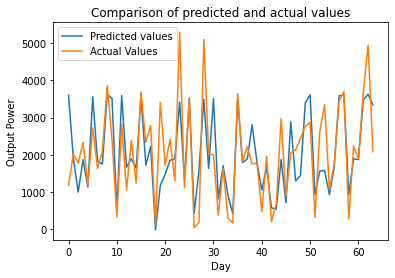

In [34]:
plt.plot(testPredict)
plt.plot(Y_Test)
plt.title('Comparison of predicted and actual values')
plt.ylabel('Output Power')
plt.xlabel('Day')
plt.legend(['Predicted values', 'Actual Values'])
plt.show()